In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from collections import Counter
import librosa
import math

In [2]:
def load_data(dataset_path):
    #open file
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
    
    #convert lists in to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    
    return inputs, targets

In [3]:
def plot_history(history):
    figure, axs = plt.subplots(2)

    # accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Train Accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Test Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Eval")

    # error subplot
    axs[1].plot(history.history["loss"], label="Train Error")
    axs[1].plot(history.history["val_loss"], label="Test Error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Eval")
    
    plt.show()

In [4]:
inputs, targets = load_data("processed.json") # load all the data

In [5]:
print(inputs.shape)
print(targets.shape)

(9986, 130, 13)
(9986,)


In [6]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3)

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6990, 130, 13) (6990,)
(2996, 130, 13) (2996,)


In [8]:
# build the model architecture
model = keras.Sequential([
    #input layer
    keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
    
    #hidden layers
    keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    #output layer
    keras.layers.Dense(units=10, activation='linear')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.summary()

c:\Users\ayush\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# train the model on training set
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1503 - loss: 43.2084 - val_accuracy: 0.2253 - val_loss: 3.6777
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1794 - loss: 8.2411 - val_accuracy: 0.1612 - val_loss: 3.4431
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1838 - loss: 5.0357 - val_accuracy: 0.1472 - val_loss: 3.4570
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1659 - loss: 4.1454 - val_accuracy: 0.1442 - val_loss: 3.4443
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1746 - loss: 3.8003 - val_accuracy: 0.1522 - val_loss: 3.4278
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1596 - loss: 3.7390 - val_accuracy: 0.1565 - val_loss: 3.4160
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1726 - loss: 3.5762 - val_accuracy: 0.1662 - val_loss: 3.3968
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1728 - loss: 3.4992 - val_a

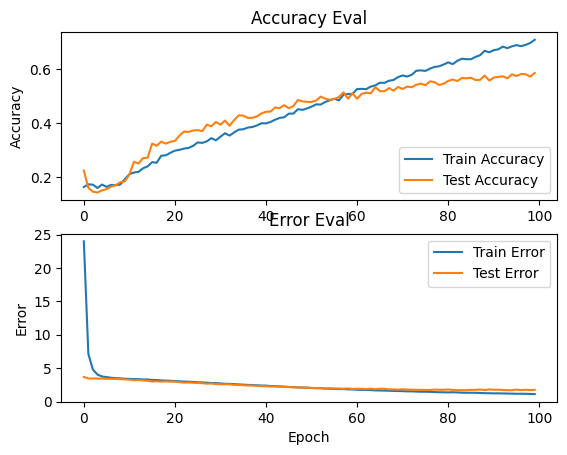

In [10]:
plot_history(history)

In [21]:
model.save("weights/weights.keras")

In [ ]:
mapping = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

In [ ]:
# Function to extract MFCCs from audio file
def extract_mfccs_from_audio(
    file_path,
    segment_duration=3,
    n_mfcc=13,
    n_fft=2048,
    hop_length=512,
    sample_rate=22050,
):
    signal, sr = librosa.load(file_path, sr=sample_rate)

    # Calculate the number of samples per segment
    samples_per_segment = sample_rate * segment_duration
    expected_vector_length = math.ceil(samples_per_segment / hop_length)

    mfccs = []
    num_segments = int(len(signal) / samples_per_segment)

    for s in range(num_segments):
        start_sample = samples_per_segment * s
        finish_sample = start_sample + samples_per_segment

        if finish_sample > len(signal):
            break

        mfcc = librosa.feature.mfcc(
            y=signal[start_sample:finish_sample],
            sr=sr,
            n_fft=n_fft,
            n_mfcc=n_mfcc,
            hop_length=hop_length,
        )
        mfcc = mfcc.T

        if len(mfcc) == expected_vector_length:
            mfccs.append(mfcc.tolist())

    return np.array(mfccs)

In [ ]:
# Load the weights
model.load_weights("weights/weights.keras")

In [ ]:
mfccs = extract_mfccs_from_audio("sample songs/master.mp3")
predictions = model.predict(mfccs)

probabilities = tf.nn.softmax(predictions, axis=-1)

predicted_classes = np.argmax(probabilities, axis=1)

class_counts = Counter(predicted_classes)
most_common_class = mapping[class_counts.most_common(1)[0][0]]

print(f"The predicted class for the song is: {most_common_class}")